# Reddit RAInger: Classifying Reddit Title using Naive Bayesian Classifier

Members:

Lorico, Hans Daniel

Luteria, Jian Lawrence

Punsalan, Lara Angeline

Rosales, Christian Jay


## Project Summary
This project aims to develop an artificial intelligence (AI) model that can accurately predict and classify Reddit post headers as either Not Safe For Work (NSFW) or Safe For Work (SFW) using the Naive Bayes method. Using a dataset obtained from Kaggle, an online data science database platform, this project will help users to be notified of the potential risks in case they encounter an NSFW subreddit. Particularly, Redditors (or users of Reddit), researchers, moderators of subreddits will directly benefit from this project.

At the end of the entire project, the team intends to produce a web application that shall filter Reddit post titles as either NSFW or SFW.

## 1. Importing the Data
The data set we used is from the Kaggle post [Reddit post title - NSFW or SFW](https://www.kaggle.com/datasets/drsourcecode/reddit-post-title-nsfw-or-sfw). It has the following columns:
- `title`: a string showing the title of the Reddit post.
- `subreddit`: a string showing the subreddit where the post came from.
- `is_nsfw`: a boolean value that is `true` if the post is NSFW and `false` if it is SFW. This will be used as a label for the model.


For faster runtime, we used 10% of the data (i.e., approximately 50,000 entries).


In [2]:
# Import data
import pandas as pd
data = pd.read_csv('kaggle_reddit-nsfw-classification-data.csv')

# Sample data for faster runtimes
data = data.sample(frac=0.1, random_state=42)

data.head()

,title,subreddit,is_nsfw
363285,If only Sibelius had 22va lines...,classicalmusic,False
82884,[buy] SPH video or snap session,Sexsells,True
515983,Did Bill Clinton bang Kyle’s Mum?,southpark,True
489579,I painted this over the weekend and then found...,painting,False
179433,Where are Promenade and Farmland in Ground War...,modernwarfare,False


From the code section below, we can observe the following information from the subset of the data set that we will use for the model:
- 51,614 entries were classified as *safe for work*.
- 10,181 entries were classified as *not safe for work*.

In [3]:
# examine the class distribution
data.is_nsfw.value_counts()

is_nsfw
False    51614
True     10181
Name: count, dtype: int64

## 2. Preprocessing
We first convert the label we will use (i.e., the `is_nsfw` column) to a numerical value. 0 indicates `False` and 1 indicates `True`.

In [4]:
# convert label to a numerical variable
data['label_num'] = data.is_nsfw.map({False:0, True:1})
data.head()

,title,subreddit,is_nsfw,label_num
363285,If only Sibelius had 22va lines...,classicalmusic,False,0
82884,[buy] SPH video or snap session,Sexsells,True,1
515983,Did Bill Clinton bang Kyle’s Mum?,southpark,True,1
489579,I painted this over the weekend and then found...,painting,False,0
179433,Where are Promenade and Farmland in Ground War...,modernwarfare,False,0


We then split the data into training and testing sets. The training set has 43256 entries (70% of the data) while the testing set has 18539 (30% of the the data).

In [5]:
# split X and y into training and testing sets

X = data['title']
y = data['label_num']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.7)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(43256,)
(18539,)
(43256,)
(18539,)


We then import `nltk`, which allows us remove stopwords as well as perform lemmatization.

In [6]:
# Import NLTK and make sure the relevant libraries are downloaded
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading omw-1.4: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


False

In the following code block, we perform the following:
1. Extract the reddit titles into a variable called `titles`.
2. Convert all the elements in `titles` into lowercase.
3. Remove URLs and unwanted characters in all elements in `titles` and store the result in `text`.
4. Remove punctuations and stopwords found in all elements in `text`and store the result in `tok_list`.
5. Tokenize and Lemmatize all the elements in `tok_list`.

In [7]:
# Extract the reddit titles
titles = data['title'].dropna()

# Convert all titles to lowercase
titles = titles.str.lower()

# Remove punctuation from titles, remove stopwords then tokenize
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import unicodedata

lemmatizer = WordNetLemmatizer()


def tokenizer(text):
    # URL Removal
    text = re.sub(r"http\S+", "", text)

    # Normalize characters
    text = unicodedata.normalize('NFKD', text)
    text = re.sub(r"[^0-9 \w _]+", " ", text)

    # Punctuation Removal
    text = "".join([c for c in text if c.isalnum() or c == " "])

    # Tokenization
    tok_list = nltk.word_tokenize(text)

    # Stopword Removal
    tok_list = [
        word for word in tok_list if word not in stopwords.words("english")]

    # Lemmatization
    tok_list = [lemmatizer.lemmatize(word) for word in tok_list]

    return tok_list

In the following code section, we first perform text feature extraction using `CountVectorizer`. Note that the `CountVectorizer` instance has the following parameters:
 - `tokenizer`: set to a predefined tokenizer.
 - `max_df`: set to 0.8, indicating that only terms appearing in at least 80% of the documents will be included in the vocabulary.
 - `token_pattern`: set to `None`, indicating that we will not use a specific token pattern.
 - `ngram_range`: set to `(1,1)`, indicating that unigrams will be used.


After that, we transform the text data into a numerical representation using Dask for parallel processing. To do that, we perform the following steps:
1. Create a Dask client and connect it to a local cluster as shown in Line 13.
2. Create a Dask parallel backend using `joblib.parallel_backend('dask')`.

Within the dask parallel backend, we:
1. fit and transform the `CountVectorizer` instance to `X_train`.
2. transform `X_test`.

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

# Generate features
vectorizer = CountVectorizer(tokenizer=tokenizer,
                             max_df=0.8, token_pattern = None,
                             ngram_range=(1,1))


# User Dask joblib to parallelize task
import joblib
from dask.distributed import Client

client = Client(processes=False)

with joblib.parallel_backend('dask'):
    X_final_train = vectorizer.fit_transform(X_train)
    X_final_test = vectorizer.transform(X_test)

/Users/larapunsalan/CS-180-AI-Final-Project/venv/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50615 instead
  warnings.warn(


KeyboardInterrupt: 

# 3. Model
In the code section below, we now train a **Multinomial Naive Bayes classifier** on`X_final_train` and predict the class labels for `X_final_test`.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_final_train, y_train)

y_final_pred = nb.predict(X_final_test)

# 4. Testing the Model's Accuracy
Using metrics and a confusion matrix, we can observe that the model has an accuracy of over 90%.

In [ ]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_final_pred)

0.9131021090673714

Text(91.68, 0.5, 'true value')

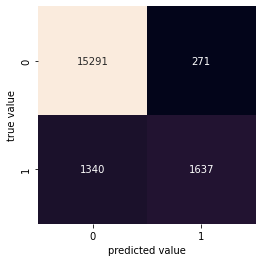

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_final_pred)
sns.heatmap(mat, square = True, annot = True, cbar = False, fmt='g')
plt.xlabel('predicted value')
plt.ylabel('true value')

# 5. Data Visualization
We can visualize the data as a word cloud as shown below.

To obtain the word frequency, we can perform the following code. This essentially creates a dictionary wherein the key is the word and the value is the frequency.

In [9]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import csv
import joblib

file_name = 'kaggle_reddit-nsfw-classification-data.csv'
word_list = []

with open(file_name, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if 'is_nsfw' in row:
            word = row['is_nsfw'].strip()
            if word == 'true':
                word_list.append(row['title'].strip())

lemmatizer = WordNetLemmatizer()

def tokenizer(text):
    # URL Removal
    text = re.sub(r"http\S+", "", text)

    # Punctuation Removal
    text = "".join([c for c in text if c.isalnum() or c == " "])

    # Tokenization
    tok_list = nltk.word_tokenize(text)

    # Stopword Removal
    tok_list = [
        word for word in tok_list if word not in stopwords.words("english")]

    # Lemmatization
    tok_list = [lemmatizer.lemmatize(word) for word in tok_list]

    return tok_list

counter = 0
li = []
for i in word_list:
    # if counter == 1000:
    #     break
    return_val = [item for item in tokenizer(i)]
    li.extend(return_val)
    # counter += 1

counts = Counter(li)
counts

Counter({'I': 17292,
         'like': 5402,
         'My': 3742,
         'want': 3642,
         'Im': 3583,
         'as': 2813,
         'love': 2489,
         'cock': 2418,
         'get': 2413,
         'make': 2393,
         'Would': 2212,
         'tit': 2198,
         'girl': 2198,
         'would': 2097,
         'Do': 2090,
         'fuck': 2014,
         'The': 1926,
         'think': 1890,
         'need': 1840,
         'cum': 1817,
         'vid': 1807,
         'boob': 1791,
         'sext': 1715,
         'What': 1700,
         'play': 1700,
         'rate': 1674,
         'good': 1666,
         'na': 1652,
         'little': 1629,
         'day': 1619,
         'face': 1555,
         'pic': 1511,
         'time': 1489,
         'see': 1438,
         'ready': 1422,
         'look': 1418,
         'know': 1407,
         'one': 1394,
         'first': 1357,
         'big': 1357,
         'let': 1355,
         'You': 1313,
         'Can': 1309,
         'A': 1272,
         

In [17]:
from nltk.corpus import stopwords
# remove stop words that did not get removed due to normalization of data.
test = {}
for k,v in counts.items():
    if k.lower() not in stopwords.words('english'):
        test[k] = v

print(test)

{'like': 5402, 'want': 3642, 'Im': 3583, 'love': 2489, 'cock': 2418, 'get': 2413, 'make': 2393, 'Would': 2212, 'tit': 2198, 'girl': 2198, 'would': 2097, 'fuck': 2014, 'think': 1890, 'need': 1840, 'cum': 1817, 'vid': 1807, 'boob': 1791, 'sext': 1715, 'play': 1700, 'rate': 1674, 'good': 1666, 'na': 1652, 'little': 1629, 'day': 1619, 'face': 1555, 'pic': 1511, 'time': 1489, 'see': 1438, 'ready': 1422, 'look': 1418, 'know': 1407, 'one': 1394, 'first': 1357, 'big': 1357, 'let': 1355, 'foot': 1230, 'pussy': 1219, 'gfe': 1219, 'fun': 1195, 'cam': 1179, 'horny': 1142, 'OC': 1127, 'new': 1126, 'asshole': 1106, 'today': 1087, 'take': 1078, 'amp': 1077, 'hope': 1072, 'dont': 1048, 'F': 1027, 'body': 1022, 'guy': 1009, 'hard': 989, 'dick': 974, 'u': 913, 'got': 912, 'right': 897, 'help': 888, 'MF': 886, 'friend': 876, 'milf': 875, 'hole': 871, 'year': 861, 'suck': 847, 'custom': 838, 'tight': 827, 'feel': 816, 'small': 814, 'cute': 811, 'wan': 810, 'video': 808, 'Let': 798, 'better': 795, 'morning

Using [this wordcloud website](https://www.wordclouds.com), we can have the following visualization.

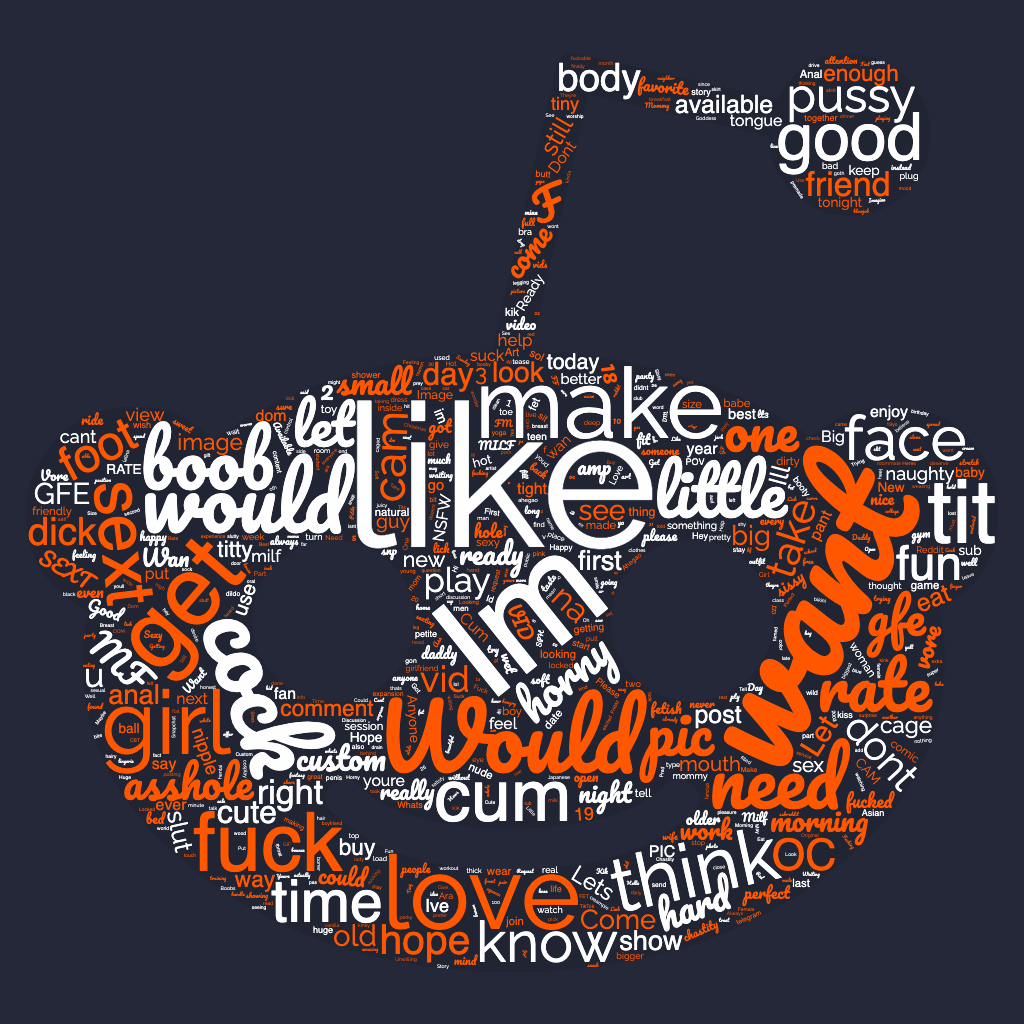